# C14-hepatocyte analysis

In [29]:
# m = c14.models.liver.A()

# path = c14.models.liver.default_path

# from scipy.interpolate import UnivariateSpline

# ploidy_data = pd.read_excel(path)
# ploidy_data['age'] = (ploidy_data[['age_min', 'age_max']].
#                       mean(axis='columns'))
# ploidy_data /= 100.0
# ploidy_data['age'] *= 100

# ploidy = UnivariateSpline(ploidy_data['age'].values,
#                                ploidy_data['2C_mean'].values,
#                                ext=3, k=2)

# t = np.linspace(0, 100)
# plt.plot(t, m.ploidy(t))
# plt.plot(t, ploidy(t))

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [30]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

mem = joblib.Memory(location='/scratch/tmp/fabrost/hepato', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                             filemode='a',
#                             format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                             level=logging.INFO)
logging.basicConfig(level=logging.WARNING)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [31]:
# logger = logging.getLogger()
# logger.setLevel(logging.WARNING)

In [32]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

## Data

In [33]:
data = pd.read_csv('../../../results/C14data_liver_samples_20190827.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

## Fit the models

In [34]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'],data=edata,step_size=2)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'], ignore_physics=True)
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [35]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [36]:
# models = c14.models.liver.models_list + c14.models.minimal.models_list
models = c14.models.liver.models_list + c14.models.minimal.models_list[-2:]
# models.remove(c14.models.liver.Hr40)
# models.remove(c14.models.liver.Al4s)
# models.remove(c14.models.liver.Akr40_d2lin)
# models.remove(c14.models.liver.Ar2r4)
# models.remove(c14.models.liver.Akr40q)
# models.remove(c14.models.liver.Akr402x2n)
models = [c14.models.liver.A]
models

[c14.models.liver.A]

In [37]:
init_limit = {'r2': (-3, 0), 
              'r4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3),
              'lambda_': (-3, 0),
              'r2_0': (-3, 0),
              'r2_1': (-3, 0),
              'r2_100': (-3, 0),
              't_step': (np.log10(5), np.log10(70))
             }

In [38]:
%%time
results = fit_models(edata, models, step_size=2, 
                     optimize_minuit_multistart_kwargs=dict(n=3, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

Fitting model A
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]


/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/fabrost/pksCloud/projects/C14_liver/source/c14/c14/models/base.py:103: RuntimeWarning: overflow encountered in double_scalars
  p_phy[p] = 10**p_fit[p]
/home/fabrost/pksCloud/projects/C14_liver/source/c14/c14/models/base.py:103: RuntimeWarning: overflow encountered in double_scalars
  p_phy[p] = 10**p_fit[p]
/home/fabrost/pksCloud/projects/C14_liver/source/c14/c14/models/base.py:103: RuntimeWarning: overflow encountered in double_scalars
  p_phy[p] = 10**p_fit[p]


CPU times: user 3.9 s, sys: 128 ms, total: 4.03 s
Wall time: 32.4 s


In [39]:
# %%time
# results = fit_models(edata, models, step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=100, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [40]:
# %%time
# results_C = fit_models(edata, [c14.models.liver.C], step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=1000, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [41]:
# %%time
# results_C10000 = fit_models(edata, [c14.models.liver.C], step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=10000, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [42]:
# results['C'] = results_C10000['C']

In [43]:
parameters = pd.concat(
    [result['vis'].get_parameter(result['point_estimate'], 
                                 result['cov'], 
                                 t_eval=[0, 80])
     .assign(model = name).reset_index() for name, result in results.items()
    ], ignore_index=True)

In [44]:
parameters['point_estimate'] = parameters['point_estimate'].astype(float)
parameters['lower'] = parameters['lower'].astype(float)
parameters['upper'] = parameters['upper'].astype(float)
parameters['parameter'] = parameters['parameter'].astype(str)
parameters['time'] = parameters['time'].astype(str)

In [45]:
parameters.head()

,time,parameter,point_estimate,lower,upper,model
0,0,delta2,4.552167e-01,0.009446,21.937913,A
1,0,delta4,9.534782e-02,0.003906,2.327535,A
2,0,kappa24,7.833019e-03,0.007833,0.007833,A
3,0,kappa42,9.499230e-33,0.000000,inf,A
4,0,lambda2,4.700138e-01,0.470014,0.470014,A


In [46]:
parameters['ymin'] = parameters['point_estimate'] - parameters['lower']
parameters['ymax'] = parameters['upper'] - parameters['point_estimate']

## Parameter Values

### Detailed

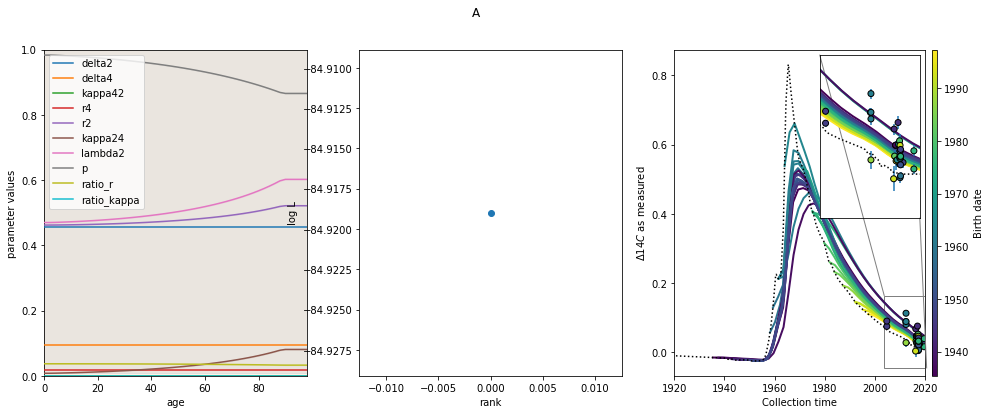

point_estimate        lower        upper
time parameter                                           
0    delta2            0.455217   0.00944585      21.9379
     delta4           0.0953478   0.00390594      2.32753
     kappa24         0.00783302   0.00783302   0.00783302
     kappa42        9.49923e-33            0          inf
     lambda2           0.470014     0.470014     0.470014
     p                 0.983334     0.983334     0.983334
     r2                0.462181     0.462181     0.462181
     r4               0.0170591            0          inf
     ratio_kappa    1.21272e-30  1.21272e-30  1.21272e-30
     ratio_r            0.03691      0.03691      0.03691

In [47]:
for name, result in results.items():
    if name not in ['']:
        if name[-4:] == 'step':
            no_plot = ['delta', 'lambda_']
        else:
            no_plot = ['delta']
        fig, axs = plt.subplots(1, 3, figsize=(16,6))
        fig.suptitle(name)
        result['vis'].plot_parameter(result['point_estimate'], result['errors'],
                                         no_plot=no_plot, axis=axs[0])

        axs[0].legend()
        axs[0].set_ylabel('parameter values')
        axs[0].set_ylim(0, 1)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('log L')
    #         axs[1].set_xlim(0, 100)
        
        _ = result['vis'].odeint()
        result['vis'].plot_simdata( axis=axs[2], cmap=plt.cm.viridis)
        axs[2].set_xlim(1920, 2020)

        plt.show()

        try:
            display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0]
                                               ))
        except:
            pass

In [48]:
results['A']

{'model': 
 Parameters are:
 delta2 = 0.4552167414752683
 delta4 = 0.09534781859552399
 kappa42 = 9.499229595018904e-33
 r4 = 0.01705907609070816
 
 Implicit Parameters are:
 r2 = [0.46218079983484084, 0.4659384362130925, 0.4763232098871432, 0.4984251182686042, 0.5214571975814469]
 kappa24 = [0.007833019073503925, 0.013732335406695873, 0.02707811225627305, 0.05369796815626222, 0.0808436402927711]
 lambda2 = [0.47001381890834476, 0.4796707716197884, 0.5034013221434163, 0.5521230864248664, 0.6023008378742181]
 p = [0.9833344919694129, 0.9713713317150355, 0.946209691820081, 0.9027427588584099, 0.8657753149105627]
 ratio_r = [0.0369099627176295, 0.03661229631398418, 0.03581407694735266, 0.03422595584662112, 0.0327142403438466]
 ratio_kappa = [1.2127162599604953e-30, 6.917417404753374e-31, 3.508084132718028e-31, 1.7690109926274949e-31, 1.175012599707031e-31]
 
 Variables are t=[0,25,50,75,100]:
 n2
 n4
 q
 
 Default parameters are:
 r4 = -1.0
 kappa42 = -1.0
 delta2 = -1.0
 delta4 = -1.0
 


### Summarized

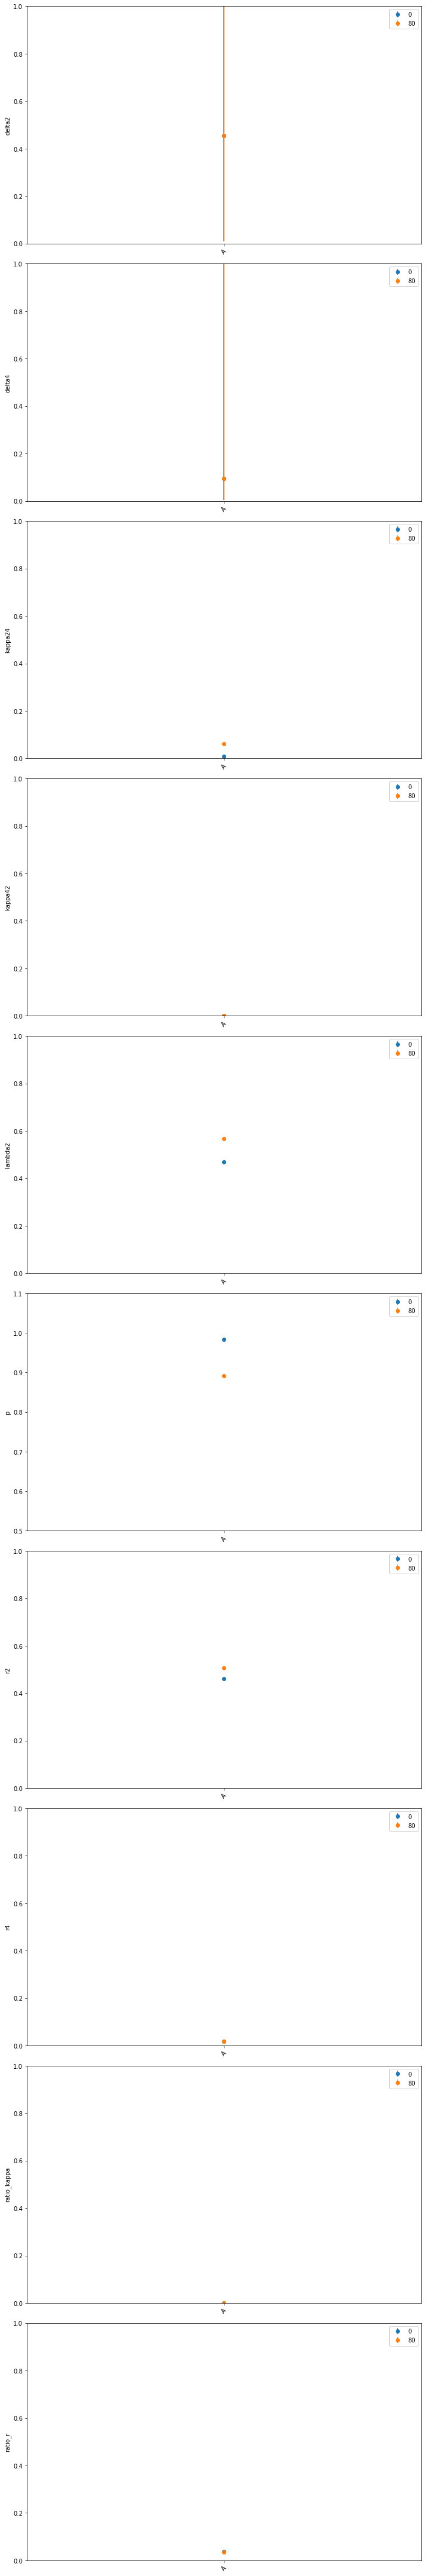

In [49]:
groupby = parameters.groupby('parameter')
fig, axs = plt.subplots(len(groupby), figsize=(10, 60))

ylimits = {'delta2': (0, 1),
           'p': (0.5, 1.1)}

for group, ax in zip(groupby, axs):
    parameter, data = group
    for time, time_data in data.groupby('time'):
        ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
                    data=time_data, marker='o', ls='None', label=time)
        ax.legend()
        ax.set_ylabel(parameter)
    try:
        ax.set_ylim(ylimits[parameter])
    except:
        ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

## Export

In [50]:
model = 'A'

In [51]:
time = np.linspace(0, 100, 101)
df = pd.DataFrame(results[model]['model'].get_implicit_parameters(time))[['r2', 'kappa24', 'ratio_r', 'p']]
# df.columns=['r2', 'r4', 'kappa24', 'kappa42', 'ratio_r']
df['r4'] = results[model]['model'].r4
df['kappa42'] = results[model]['model'].kappa42
df['delta2'] = results[model]['model'].delta2
df['delta4'] = results[model]['model'].delta4
df['age'] = time
df['ploidy'] = c14.models.liver.A().ploidy(df['age'])
df.head()

,r2,kappa24,ratio_r,p,r4,kappa42,delta2,delta4,age,ploidy
0,0.462181,0.007833,0.036910,0.983334,0.017059,9.499230e-33,0.455217,0.095348,0.0,0.918313
1,0.462181,0.007833,0.036910,0.983334,0.017059,9.499230e-33,0.455217,0.095348,1.0,0.918313
2,0.462181,0.007833,0.036910,0.983334,0.017059,9.499230e-33,0.455217,0.095348,2.0,0.918313
3,0.462219,0.007916,0.036907,0.983162,0.017059,9.499230e-33,0.455217,0.095348,3.0,0.917904
4,0.462301,0.008089,0.036900,0.982804,0.017059,9.499230e-33,0.455217,0.095348,4.0,0.917023


In [52]:
result = results[model]
df = result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=time).unstack().reset_index()

In [53]:
df = df[['time', 'point_estimate']]

In [54]:
df.to_excel('../../../results/parameters_A.xlsx')

## Model selection

In [55]:
model_selection_results = pd.DataFrame(pd.Series({name: result['op'].calc_aicc(result['point_estimate']) for name, result in results.items()}, name='cAIC'))
model_selection_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for name, result in results.items()]
model_selection_results['nparas'] = [result['model'].nparas for name, result in results.items()] 
model_selection_results['nparas'] += 1
model_selection_results = pd.DataFrame(model_selection_results)
model_selection_results['delta'] = model_selection_results['cAIC'] - model_selection_results['cAIC'].min() 
model_selection_results['w'] = np.exp(-0.5*model_selection_results['delta']) / np.exp(-0.5*model_selection_results['delta']).sum()
model_selection_results['ER'] = model_selection_results['w'].max() / model_selection_results['w']
model_selection_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
A,-157.615754,84.918988,5,0.0,1.0,1.0
